In [1]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import random

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import Compose, ToTensor, Normalize, RandomHorizontalFlip, Resize
from torchvision.transforms import functional as TF

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from torch.nn.functional import interpolate

from tqdm import tqdm

from sklearn.metrics import jaccard_score

Image count per folder: {'train': 137, 'train_labels': 137, 'val': 4, 'val_labels': 4, 'test': 10, 'test_labels': 10}


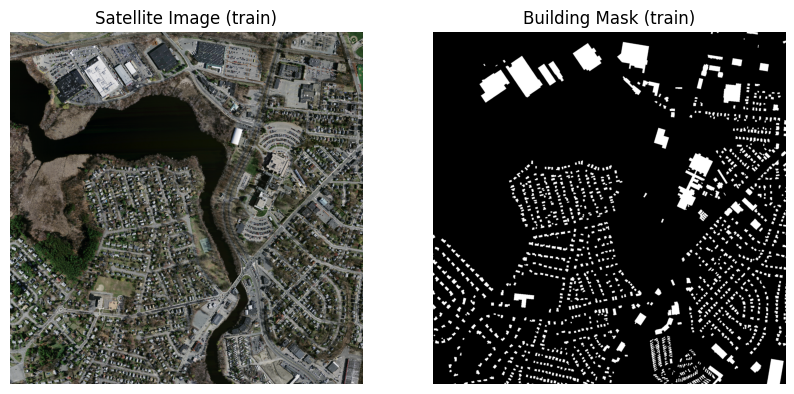

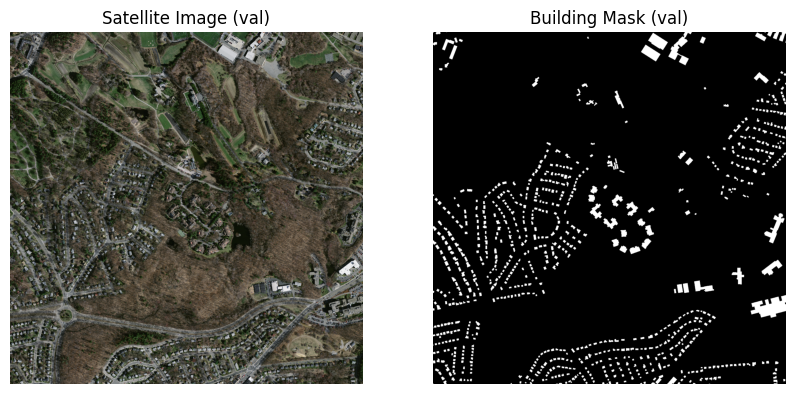

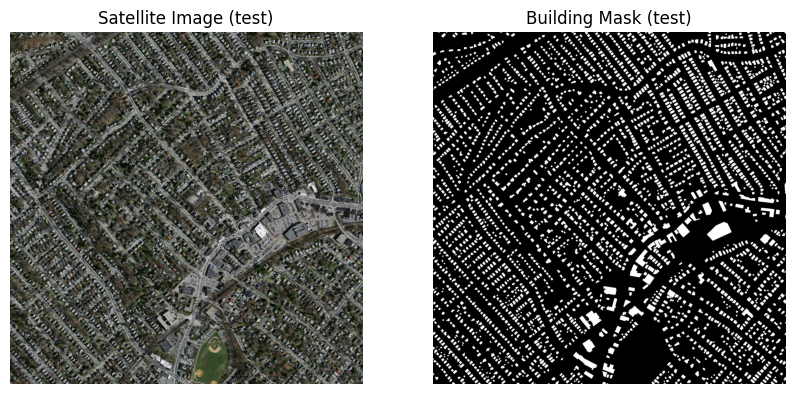

In [2]:
def explore_images(base_path):
    # Define the categories of the folders containing the images and their labels
    categories = ['train', 'train_labels', 'val', 'val_labels', 'test', 'test_labels']
    image_counts = {}
    
    # Iterate over each category to count the image files
    for category in categories:
        # Build the full path to the category folder
        path = os.path.join(base_path, category)
        # Count and store the number of files in each category
        image_counts[category] = len([name for name in os.listdir(path) if os.path.isfile(os.path.join(path, name))])
    
    # Print a summary of the image count for each folder
    print("Image count per folder:", image_counts)
    
    # Categories containing images for display
    sample_images = ['train', 'val', 'test']
    for category in sample_images:
        # Get the list of image files and labels
        images_list = os.listdir(os.path.join(base_path, category))
        labels_list = os.listdir(os.path.join(base_path, f"{category}_labels"))
        
        # Check if the image and label lists are not empty
        if images_list and labels_list:
            # Select the first image and label from the lists for display
            image_path = os.path.join(base_path, category, images_list[0])
            label_path = os.path.join(base_path, f"{category}_labels", labels_list[0])
            
            # Open the image and label with Pillow
            image = Image.open(image_path)
            label = Image.open(label_path)
            
            # Set up the display environment with Matplotlib
            fig, ax = plt.subplots(1, 2, figsize=(10, 5))
            ax[0].imshow(image)
            ax[0].set_title(f'Satellite Image ({category})')
            ax[0].axis('off')
            
            ax[1].imshow(label, cmap='gray')
            ax[1].set_title(f'Building Mask ({category})')
            ax[1].axis('off')
            
            # Display the images and labels
            plt.show()

# Get the current directory and use it to call the function
current_directory = os.getcwd()
explore_images(os.path.join(current_directory, 'MBDS/png'))

In [3]:
class SatelliteBuildingDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform_image=None, transform_mask=None):
        """
        Initializes the SatelliteBuildingDataset class with specific directories for images and masks,
        and with optional transformations that can be applied to both images and masks.

        Args:
            image_dir (string): Directory containing all images.
            mask_dir (string): Directory containing all masks.
            transform_image (callable, optional): Optional transformation function to apply to images.
            transform_mask (callable, optional): Optional transformation function to apply to masks.
        """
        # Assign to instance variables the values of the parameters
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform_image = transform_image
        self.transform_mask = transform_mask
        # List all files in the image directory. It is assumed that each image has its corresponding mask.
        self.images = os.listdir(image_dir)

    def __len__(self):
        # Returns the total number of images in the dataset
        return len(self.images)

    def __getitem__(self, idx):
        # Build the full paths for the image and mask using the provided index
        img_name = os.path.join(self.image_dir, self.images[idx])
        mask_name = os.path.join(self.mask_dir, self.images[idx])
        
        # Open the image and convert it to RGB color
        image = Image.open(img_name).convert("RGB")
        # Open the mask and convert it to grayscale so that it has a single channel
        mask = Image.open(mask_name).convert("L")  

        # Apply the specified transformations to the image and mask, if provided
        if self.transform_image:
            image = self.transform_image(image)
        if self.transform_mask:
            mask = self.transform_mask(mask)

        # Return the processed image and mask
        return image, mask

In [4]:
def create_dataloaders(base_path, resize, batch_size=4):
    """
    Creates and returns dataloaders for training and validation datasets.
    
    Args:
        base_path (str): Base path where the data folders are located.
        resize (tuple): Dimensions to which all images and masks will be resized.
        batch_size (int, optional): Number of samples per batch. The default value is 4.
    """
    
    # Define transformations to apply to the images:
    # - Resize the images to the specified size.
    # - Convert the images to PyTorch tensors.
    # - Normalize the images using specified means and standard deviations.
    transform_image = Compose([
        Resize(resize),
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Define transformations for the masks, which include resizing and conversion to tensor.
    # Masks generally do not require normalization.
    transform_mask = Compose([
        Resize(resize),
        ToTensor()
    ])

    # Build full paths to the training and validation image and mask directories
    train_dir = os.path.join(base_path, 'train')
    train_mask_dir = os.path.join(base_path, 'train_labels')
    val_dir = os.path.join(base_path, 'val')
    val_mask_dir = os.path.join(base_path, 'val_labels')
    
    # Create the training and validation datasets using the SatelliteBuildingDataset class
    train_dataset = SatelliteBuildingDataset(train_dir, train_mask_dir, transform_image, transform_mask)
    val_dataset = SatelliteBuildingDataset(val_dir, val_mask_dir, transform_image, transform_mask)

    # Create dataloaders for the training and validation datasets.
    # The training dataloader shuffles the data (shuffle=True) to improve training.
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Return the training and validation dataloaders
    return train_loader, val_loader

In [5]:
# Assuming you are running this from the main directory of your project
base_path = os.getcwd()
base_path = os.path.join(base_path, 'MBDS/png')

In [6]:
# We create the model, as well as the loss function. 
# The model is of the U-Net type, with 4 encoder downsampling blocks and 4 decoder upsampling blocks.

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        """
        Double convolution block that applies two convolution layers with a batch normalization 
        and ReLU activation between them.

        Args:
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels.
        """
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)
    
    
class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        """
        DownBlock in U-Net that includes a DoubleConv followed by max pooling 
        to reduce spatial dimension.

        Args:
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels after DoubleConv.
        """
        super(DownBlock, self).__init__()
        self.double_conv = DoubleConv(in_channels, out_channels)
        self.down_sample = nn.MaxPool2d(2)

    def forward(self, x):
        skip_out = self.double_conv(x)
        down_out = self.down_sample(skip_out)
        return (down_out, skip_out)

    
class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, up_sample_mode):
        """
        UpBlock in U-Net that performs upsampling and combines features
        from earlier layers through concatenation operation.

        Args:
            in_channels (int): Total number of input channels (sum of output channels from previous block and skip connection).
            out_channels (int): Number of output channels.
            up_sample_mode (str): Upsampling mode, 'conv_transpose' for ConvTranspose2d or 'bilinear' for bilinear interpolation.
        """
        super(UpBlock, self).__init__()
        if up_sample_mode == 'conv_transpose':
            self.up_sample = nn.ConvTranspose2d(in_channels - out_channels, in_channels - out_channels, kernel_size=2, stride=2)        
        elif up_sample_mode == 'bilinear':
            self.up_sample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            raise ValueError("Unsupported `up_sample_mode` (can take one of `conv_transpose` or `bilinear`)")
        self.double_conv = DoubleConv(in_channels, out_channels)

    def forward(self, down_input, skip_input):
        x = self.up_sample(down_input)
        x = torch.cat([x, skip_input], dim=1)
        return self.double_conv(x)

    
class UNet(nn.Module):
    def __init__(self, out_classes=1, up_sample_mode='conv_transpose'):
        """
        U-Net architecture for segmentation that includes descending and ascending paths with a bottleneck.

        Args:
            out_classes (int): Number of output classes (usually 1 for binary segmentation masks).
            up_sample_mode (str): Upsampling mode used in the ascent blocks.
        """
        super(UNet, self).__init__()
        self.up_sample_mode = up_sample_mode
        self.down_conv1 = DownBlock(3, 64)
        self.down_conv2 = DownBlock(64, 128)
        self.down_conv3 = DownBlock(128, 256)
        self.down_conv4 = DownBlock(256, 512)
        self.double_conv = DoubleConv(512, 1024)
        self.up_conv4 = UpBlock(1024 + 512, 512, self.up_sample_mode)
        self.up_conv3 = UpBlock(512 + 256, 256, self.up_sample_mode)
        self.up_conv2 = UpBlock(256 + 128, 128, self.up_sample_mode)
        self.up_conv1 = UpBlock(128 + 64, 64, self.up_sample_mode)
        self.conv_last = nn.Conv2d(64, out_classes, kernel_size=1)

    def forward(self, x):
        x, skip1_out = self.down_conv1(x)
        x, skip2_out = self.down_conv2(x)
        x, skip3_out = self.down_conv3(x)
        x, skip4_out = self.down_conv4(x)
        x = self.double_conv(x)
        x = self.up_conv4(x, skip4_out)
        x = self.up_conv3(x, skip3_out)
        x = self.up_conv2(x, skip2_out)
        x = self.up_conv1(x, skip1_out)
        x = self.conv_last(x)
        return x


class DiceLoss(nn.Module):
    def __init__(self, smooth=1.):
        """
        Implementation of the Dice Loss, useful for comparing the similarity between two samples.

        Args:
            smooth (float): Value to prevent division by zero and smooth the result.
        """
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        inputs = torch.sigmoid(inputs)  # Convert logits to probabilities
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()                            
        dice = (2. * intersection + self.smooth) / (inputs.sum() + targets.sum() + self.smooth)  
        
        return 1 - dice

In [7]:
# Load the model
model = UNet()
# Check if CUDA is available and move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss function and optimizer
criterion = DiceLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [8]:
# We add the IoU as a metric to see how the model progresses and performs. 
# The training metric is Dice, but it's good to have more than one metric if possible.

def calculate_iou(outputs, masks):
    """
    Calcula el promedio de la métrica Intersección sobre Unión (IoU) entre las salidas del modelo y las máscaras verdaderas.

    Args:
        outputs: Salidas del modelo (logits).
        masks: Máscaras verdaderas (ground truth).

    Returns:
        Un valor flotante que representa el IoU promedio.
    """
    outputs = torch.sigmoid(outputs) > 0.5  # Convertir logits a predicciones binarias
    outputs = outputs.cpu().numpy().astype(np.uint8)  # Convertir a NumPy para cálculo
    masks = masks.cpu().numpy().astype(np.uint8)
    
    # Calcular IoU para cada par de salida y máscara
    ious = [jaccard_score(m.flatten(), o.flatten()) for m, o in zip(masks, outputs)]
    return np.mean(ious)

def weight_reset(m):
    """
    Reinicia los pesos de las capas convolucionales y lineales a sus valores iniciales.

    Args:
        m: Módulo de PyTorch (capa).
    """
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()

Training model with image size: (256, 256)


Epoch 1/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.36it/s]


Epoch 1/500, Train Loss: 0.7031, Val Loss: 0.7004, Average IoU: 0.0998
Model saved to saved_models\model_256x256.pth


Epoch 2/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.41it/s]


Epoch 2/500, Train Loss: 0.6499, Val Loss: 0.6733, Average IoU: 0.0605
Model saved to saved_models\model_256x256.pth


Epoch 3/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.38it/s]


Epoch 3/500, Train Loss: 0.6314, Val Loss: 0.6028, Average IoU: 0.0952
Model saved to saved_models\model_256x256.pth


Epoch 4/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.50it/s]


Epoch 4/500, Train Loss: 0.6164, Val Loss: 0.5914, Average IoU: 0.0949
Model saved to saved_models\model_256x256.pth


Epoch 5/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.36it/s]


Epoch 5/500, Train Loss: 0.6009, Val Loss: 0.5761, Average IoU: 0.0978
Model saved to saved_models\model_256x256.pth


Epoch 6/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.31it/s]


Epoch 6/500, Train Loss: 0.5907, Val Loss: 0.5699, Average IoU: 0.1035
Model saved to saved_models\model_256x256.pth


Epoch 7/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.35it/s]


Epoch 7/500, Train Loss: 0.5766, Val Loss: 0.5697, Average IoU: 0.1062
Model saved to saved_models\model_256x256.pth


Epoch 8/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.33it/s]


Epoch 8/500, Train Loss: 0.5764, Val Loss: 0.5511, Average IoU: 0.1084
Model saved to saved_models\model_256x256.pth


Epoch 9/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


Epoch 9/500, Train Loss: 0.5583, Val Loss: 0.5500, Average IoU: 0.1002
Model saved to saved_models\model_256x256.pth


Epoch 10/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.32it/s]


Epoch 10/500, Train Loss: 0.5534, Val Loss: 0.5291, Average IoU: 0.1129
Model saved to saved_models\model_256x256.pth


Epoch 11/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.30it/s]


Epoch 11/500, Train Loss: 0.5446, Val Loss: 0.5301, Average IoU: 0.1091


Epoch 12/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.41it/s]


Epoch 12/500, Train Loss: 0.5348, Val Loss: 0.5405, Average IoU: 0.0897


Epoch 13/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.40it/s]


Epoch 13/500, Train Loss: 0.5284, Val Loss: 0.5259, Average IoU: 0.1030
Model saved to saved_models\model_256x256.pth


Epoch 14/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.41it/s]


Epoch 14/500, Train Loss: 0.5216, Val Loss: 0.5124, Average IoU: 0.1110
Model saved to saved_models\model_256x256.pth


Epoch 15/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.41it/s]


Epoch 15/500, Train Loss: 0.5164, Val Loss: 0.5233, Average IoU: 0.1067


Epoch 16/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.43it/s]


Epoch 16/500, Train Loss: 0.5065, Val Loss: 0.5088, Average IoU: 0.1096
Model saved to saved_models\model_256x256.pth


Epoch 17/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.40it/s]


Epoch 17/500, Train Loss: 0.4991, Val Loss: 0.4845, Average IoU: 0.1152
Model saved to saved_models\model_256x256.pth


Epoch 18/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.53it/s]


Epoch 18/500, Train Loss: 0.4939, Val Loss: 0.4841, Average IoU: 0.1147
Model saved to saved_models\model_256x256.pth


Epoch 19/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.29it/s]


Epoch 19/500, Train Loss: 0.4790, Val Loss: 0.4813, Average IoU: 0.1192
Model saved to saved_models\model_256x256.pth


Epoch 20/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.39it/s]


Epoch 20/500, Train Loss: 0.4743, Val Loss: 0.4758, Average IoU: 0.1178
Model saved to saved_models\model_256x256.pth


Epoch 21/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.30it/s]


Epoch 21/500, Train Loss: 0.4627, Val Loss: 0.4709, Average IoU: 0.1175
Model saved to saved_models\model_256x256.pth


Epoch 22/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.28it/s]


Epoch 22/500, Train Loss: 0.4607, Val Loss: 0.4691, Average IoU: 0.1246
Model saved to saved_models\model_256x256.pth


Epoch 23/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.19it/s]


Epoch 23/500, Train Loss: 0.4460, Val Loss: 0.4682, Average IoU: 0.1147
Model saved to saved_models\model_256x256.pth


Epoch 24/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.39it/s]


Epoch 24/500, Train Loss: 0.4405, Val Loss: 0.4603, Average IoU: 0.1128
Model saved to saved_models\model_256x256.pth


Epoch 25/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


Epoch 25/500, Train Loss: 0.4414, Val Loss: 0.4817, Average IoU: 0.0972


Epoch 26/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.38it/s]


Epoch 26/500, Train Loss: 0.4348, Val Loss: 0.4520, Average IoU: 0.1247
Model saved to saved_models\model_256x256.pth


Epoch 27/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.38it/s]


Epoch 27/500, Train Loss: 0.4264, Val Loss: 0.4651, Average IoU: 0.1210


Epoch 28/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.28it/s]


Epoch 28/500, Train Loss: 0.4181, Val Loss: 0.4544, Average IoU: 0.1175


Epoch 29/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.29it/s]


Epoch 29/500, Train Loss: 0.4078, Val Loss: 0.4489, Average IoU: 0.1209
Model saved to saved_models\model_256x256.pth


Epoch 30/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.32it/s]


Epoch 30/500, Train Loss: 0.4065, Val Loss: 0.4480, Average IoU: 0.1180
Model saved to saved_models\model_256x256.pth


Epoch 31/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.42it/s]


Epoch 31/500, Train Loss: 0.3970, Val Loss: 0.4350, Average IoU: 0.1213
Model saved to saved_models\model_256x256.pth


Epoch 32/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.43it/s]


Epoch 32/500, Train Loss: 0.3933, Val Loss: 0.4374, Average IoU: 0.1185


Epoch 33/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.40it/s]


Epoch 33/500, Train Loss: 0.3866, Val Loss: 0.4332, Average IoU: 0.1216
Model saved to saved_models\model_256x256.pth


Epoch 34/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.42it/s]


Epoch 34/500, Train Loss: 0.3944, Val Loss: 0.4410, Average IoU: 0.1176


Epoch 35/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.39it/s]


Epoch 35/500, Train Loss: 0.3877, Val Loss: 0.4393, Average IoU: 0.1125


Epoch 36/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.33it/s]


Epoch 36/500, Train Loss: 0.3859, Val Loss: 0.4452, Average IoU: 0.1116


Epoch 37/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]


Epoch 37/500, Train Loss: 0.3799, Val Loss: 0.4218, Average IoU: 0.1219
Model saved to saved_models\model_256x256.pth


Epoch 38/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.28it/s]


Epoch 38/500, Train Loss: 0.3672, Val Loss: 0.4371, Average IoU: 0.1198


Epoch 39/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.29it/s]


Epoch 39/500, Train Loss: 0.3621, Val Loss: 0.4374, Average IoU: 0.1128


Epoch 40/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.39it/s]


Epoch 40/500, Train Loss: 0.3595, Val Loss: 0.4435, Average IoU: 0.1095


Epoch 41/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.36it/s]


Epoch 41/500, Train Loss: 0.3658, Val Loss: 0.4451, Average IoU: 0.1189


Epoch 42/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.44it/s]


Epoch 42/500, Train Loss: 0.3564, Val Loss: 0.4669, Average IoU: 0.1233


Epoch 43/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.29it/s]


Epoch 43/500, Train Loss: 0.3545, Val Loss: 0.4407, Average IoU: 0.1154


Epoch 44/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.41it/s]


Epoch 44/500, Train Loss: 0.3511, Val Loss: 0.4263, Average IoU: 0.1244


Epoch 45/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.36it/s]


Epoch 45/500, Train Loss: 0.3532, Val Loss: 0.4167, Average IoU: 0.1249
Model saved to saved_models\model_256x256.pth


Epoch 46/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.42it/s]


Epoch 46/500, Train Loss: 0.3466, Val Loss: 0.4285, Average IoU: 0.1186


Epoch 47/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.52it/s]


Epoch 47/500, Train Loss: 0.3538, Val Loss: 0.4312, Average IoU: 0.1210


Epoch 48/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.23it/s]


Epoch 48/500, Train Loss: 0.3411, Val Loss: 0.4331, Average IoU: 0.1098


Epoch 49/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.43it/s]


Epoch 49/500, Train Loss: 0.3405, Val Loss: 0.4497, Average IoU: 0.1190


Epoch 50/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


Epoch 50/500, Train Loss: 0.3425, Val Loss: 0.4549, Average IoU: 0.1152


Epoch 51/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.28it/s]


Epoch 51/500, Train Loss: 0.3317, Val Loss: 0.4223, Average IoU: 0.1176


Epoch 52/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.40it/s]


Epoch 52/500, Train Loss: 0.3363, Val Loss: 0.4260, Average IoU: 0.1240


Epoch 53/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.37it/s]


Epoch 53/500, Train Loss: 0.3317, Val Loss: 0.4386, Average IoU: 0.1161


Epoch 54/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.29it/s]


Epoch 54/500, Train Loss: 0.3291, Val Loss: 0.4215, Average IoU: 0.1208


Epoch 55/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.35it/s]


Epoch 55/500, Train Loss: 0.3241, Val Loss: 0.4184, Average IoU: 0.1218


Epoch 56/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.39it/s]


Epoch 56/500, Train Loss: 0.3210, Val Loss: 0.4303, Average IoU: 0.1066


Epoch 57/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.35it/s]


Epoch 57/500, Train Loss: 0.3210, Val Loss: 0.4269, Average IoU: 0.1198


Epoch 58/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.31it/s]


Epoch 58/500, Train Loss: 0.3236, Val Loss: 0.4395, Average IoU: 0.1181


Epoch 59/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.33it/s]


Epoch 59/500, Train Loss: 0.3163, Val Loss: 0.4454, Average IoU: 0.1191


Epoch 60/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.47it/s]


Epoch 60/500, Train Loss: 0.3188, Val Loss: 0.4233, Average IoU: 0.1188


Epoch 61/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.48it/s]


Epoch 61/500, Train Loss: 0.3143, Val Loss: 0.4557, Average IoU: 0.1035


Epoch 62/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.38it/s]


Epoch 62/500, Train Loss: 0.3151, Val Loss: 0.4283, Average IoU: 0.1160


Epoch 63/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.43it/s]


Epoch 63/500, Train Loss: 0.3107, Val Loss: 0.4294, Average IoU: 0.1255


Epoch 64/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.47it/s]


Epoch 64/500, Train Loss: 0.3109, Val Loss: 0.4341, Average IoU: 0.1182


Epoch 65/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.37it/s]


Epoch 65/500, Train Loss: 0.3079, Val Loss: 0.4340, Average IoU: 0.1098


Epoch 66/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.36it/s]


Epoch 66/500, Train Loss: 0.3071, Val Loss: 0.4237, Average IoU: 0.1163


Epoch 67/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


Epoch 67/500, Train Loss: 0.3044, Val Loss: 0.4331, Average IoU: 0.1130


Epoch 68/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.24it/s]


Epoch 68/500, Train Loss: 0.3042, Val Loss: 0.4145, Average IoU: 0.1218
Model saved to saved_models\model_256x256.pth


Epoch 69/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.35it/s]


Epoch 69/500, Train Loss: 0.3062, Val Loss: 0.4378, Average IoU: 0.1117


Epoch 70/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.37it/s]


Epoch 70/500, Train Loss: 0.3151, Val Loss: 0.4479, Average IoU: 0.1030


Epoch 71/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.33it/s]


Epoch 71/500, Train Loss: 0.3127, Val Loss: 0.4143, Average IoU: 0.1225
Model saved to saved_models\model_256x256.pth


Epoch 72/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.35it/s]


Epoch 72/500, Train Loss: 0.3029, Val Loss: 0.4339, Average IoU: 0.1179


Epoch 73/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.25it/s]


Epoch 73/500, Train Loss: 0.3087, Val Loss: 0.4360, Average IoU: 0.1292


Epoch 74/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.35it/s]


Epoch 74/500, Train Loss: 0.3023, Val Loss: 0.4145, Average IoU: 0.1260


Epoch 75/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.37it/s]


Epoch 75/500, Train Loss: 0.3008, Val Loss: 0.4278, Average IoU: 0.1228


Epoch 76/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


Epoch 76/500, Train Loss: 0.3080, Val Loss: 0.4291, Average IoU: 0.1244


Epoch 77/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.30it/s]


Epoch 77/500, Train Loss: 0.2960, Val Loss: 0.4379, Average IoU: 0.1220


Epoch 78/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.42it/s]


Epoch 78/500, Train Loss: 0.2959, Val Loss: 0.4131, Average IoU: 0.1283
Model saved to saved_models\model_256x256.pth


Epoch 79/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.33it/s]


Epoch 79/500, Train Loss: 0.2981, Val Loss: 0.4392, Average IoU: 0.1138


Epoch 80/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.36it/s]


Epoch 80/500, Train Loss: 0.2984, Val Loss: 0.4169, Average IoU: 0.1281


Epoch 81/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.31it/s]


Epoch 81/500, Train Loss: 0.2920, Val Loss: 0.4145, Average IoU: 0.1272


Epoch 82/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.39it/s]


Epoch 82/500, Train Loss: 0.2932, Val Loss: 0.4292, Average IoU: 0.1198


Epoch 83/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]


Epoch 83/500, Train Loss: 0.2951, Val Loss: 0.4085, Average IoU: 0.1273
Model saved to saved_models\model_256x256.pth


Epoch 84/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.36it/s]


Epoch 84/500, Train Loss: 0.3013, Val Loss: 0.4381, Average IoU: 0.1206


Epoch 85/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


Epoch 85/500, Train Loss: 0.2963, Val Loss: 0.4136, Average IoU: 0.1187


Epoch 86/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.32it/s]


Epoch 86/500, Train Loss: 0.2940, Val Loss: 0.4031, Average IoU: 0.1261
Model saved to saved_models\model_256x256.pth


Epoch 87/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.26it/s]


Epoch 87/500, Train Loss: 0.2898, Val Loss: 0.4257, Average IoU: 0.1184


Epoch 88/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.36it/s]


Epoch 88/500, Train Loss: 0.2909, Val Loss: 0.4230, Average IoU: 0.1294


Epoch 89/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.38it/s]


Epoch 89/500, Train Loss: 0.2898, Val Loss: 0.4351, Average IoU: 0.1063


Epoch 90/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.41it/s]


Epoch 90/500, Train Loss: 0.3014, Val Loss: 0.4397, Average IoU: 0.1088


Epoch 91/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.42it/s]


Epoch 91/500, Train Loss: 0.3119, Val Loss: 0.4506, Average IoU: 0.1036


Epoch 92/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


Epoch 92/500, Train Loss: 0.3254, Val Loss: 0.4124, Average IoU: 0.1300


Epoch 93/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.27it/s]


Epoch 93/500, Train Loss: 0.3009, Val Loss: 0.4244, Average IoU: 0.1200


Epoch 94/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.26it/s]


Epoch 94/500, Train Loss: 0.2952, Val Loss: 0.4176, Average IoU: 0.1221


Epoch 95/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.43it/s]


Epoch 95/500, Train Loss: 0.2885, Val Loss: 0.4203, Average IoU: 0.1245


Epoch 96/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.38it/s]


Epoch 96/500, Train Loss: 0.2864, Val Loss: 0.4156, Average IoU: 0.1216


Epoch 97/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.38it/s]


Epoch 97/500, Train Loss: 0.2942, Val Loss: 0.4168, Average IoU: 0.1217


Epoch 98/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.44it/s]


Epoch 98/500, Train Loss: 0.2959, Val Loss: 0.4687, Average IoU: 0.1259


Epoch 99/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.36it/s]


Epoch 99/500, Train Loss: 0.2941, Val Loss: 0.4194, Average IoU: 0.1202


Epoch 100/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.24it/s]


Epoch 100/500, Train Loss: 0.2880, Val Loss: 0.4071, Average IoU: 0.1223


Epoch 101/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.44it/s]


Epoch 101/500, Train Loss: 0.2840, Val Loss: 0.4126, Average IoU: 0.1251


Epoch 102/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.49it/s]


Epoch 102/500, Train Loss: 0.2819, Val Loss: 0.4125, Average IoU: 0.1210


Epoch 103/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.28it/s]


Epoch 103/500, Train Loss: 0.2883, Val Loss: 0.4278, Average IoU: 0.1277


Epoch 104/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.38it/s]


Epoch 104/500, Train Loss: 0.2856, Val Loss: 0.4118, Average IoU: 0.1237


Epoch 105/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.33it/s]


Epoch 105/500, Train Loss: 0.2832, Val Loss: 0.4196, Average IoU: 0.1264


Epoch 106/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.39it/s]


Epoch 106/500, Train Loss: 0.2812, Val Loss: 0.4339, Average IoU: 0.1262


Epoch 107/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.43it/s]


Epoch 107/500, Train Loss: 0.2845, Val Loss: 0.4141, Average IoU: 0.1266


Epoch 108/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.42it/s]


Epoch 108/500, Train Loss: 0.2832, Val Loss: 0.4214, Average IoU: 0.1209


Epoch 109/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.27it/s]


Epoch 109/500, Train Loss: 0.2791, Val Loss: 0.4245, Average IoU: 0.1187


Epoch 110/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]


Epoch 110/500, Train Loss: 0.2802, Val Loss: 0.4197, Average IoU: 0.1266


Epoch 111/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.38it/s]


Epoch 111/500, Train Loss: 0.2886, Val Loss: 0.4172, Average IoU: 0.1211


Epoch 112/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


Epoch 112/500, Train Loss: 0.2866, Val Loss: 0.4261, Average IoU: 0.1171


Epoch 113/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


Epoch 113/500, Train Loss: 0.2978, Val Loss: 0.4172, Average IoU: 0.1265


Epoch 114/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.39it/s]


Epoch 114/500, Train Loss: 0.2930, Val Loss: 0.4207, Average IoU: 0.1223


Epoch 115/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.35it/s]


Epoch 115/500, Train Loss: 0.2890, Val Loss: 0.4108, Average IoU: 0.1219


Epoch 116/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.27it/s]


Epoch 116/500, Train Loss: 0.2827, Val Loss: 0.4110, Average IoU: 0.1265


Epoch 117/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.43it/s]


Epoch 117/500, Train Loss: 0.2829, Val Loss: 0.4134, Average IoU: 0.1233


Epoch 118/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.60it/s]


Epoch 118/500, Train Loss: 0.2814, Val Loss: 0.4116, Average IoU: 0.1224


Epoch 119/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.46it/s]


Epoch 119/500, Train Loss: 0.2759, Val Loss: 0.4127, Average IoU: 0.1240


Epoch 120/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.46it/s]


Epoch 120/500, Train Loss: 0.2801, Val Loss: 0.4191, Average IoU: 0.1218


Epoch 121/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.38it/s]


Epoch 121/500, Train Loss: 0.2774, Val Loss: 0.4269, Average IoU: 0.1287


Epoch 122/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.43it/s]


Epoch 122/500, Train Loss: 0.2778, Val Loss: 0.4114, Average IoU: 0.1222


Epoch 123/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]


Epoch 123/500, Train Loss: 0.2774, Val Loss: 0.4140, Average IoU: 0.1279


Epoch 124/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.57it/s]


Epoch 124/500, Train Loss: 0.2779, Val Loss: 0.4113, Average IoU: 0.1262


Epoch 125/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.39it/s]


Epoch 125/500, Train Loss: 0.2773, Val Loss: 0.4109, Average IoU: 0.1252


Epoch 126/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.42it/s]


Epoch 126/500, Train Loss: 0.2754, Val Loss: 0.4769, Average IoU: 0.1053


Epoch 127/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.50it/s]


Epoch 127/500, Train Loss: 0.2914, Val Loss: 0.4310, Average IoU: 0.1199


Epoch 128/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.38it/s]


Epoch 128/500, Train Loss: 0.2842, Val Loss: 0.4145, Average IoU: 0.1228


Epoch 129/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.38it/s]


Epoch 129/500, Train Loss: 0.2765, Val Loss: 0.4185, Average IoU: 0.1201


Epoch 130/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.38it/s]


Epoch 130/500, Train Loss: 0.2759, Val Loss: 0.4115, Average IoU: 0.1217


Epoch 131/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.33it/s]


Epoch 131/500, Train Loss: 0.2807, Val Loss: 0.4262, Average IoU: 0.1149


Epoch 132/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.46it/s]


Epoch 132/500, Train Loss: 0.2789, Val Loss: 0.4173, Average IoU: 0.1211


Epoch 133/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.43it/s]


Epoch 133/500, Train Loss: 0.2762, Val Loss: 0.4273, Average IoU: 0.1190


Epoch 134/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.32it/s]


Epoch 134/500, Train Loss: 0.2764, Val Loss: 0.4126, Average IoU: 0.1246


Epoch 135/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.40it/s]


Epoch 135/500, Train Loss: 0.2771, Val Loss: 0.4166, Average IoU: 0.1249


Epoch 136/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.48it/s]


Epoch 136/500, Train Loss: 0.2723, Val Loss: 0.4183, Average IoU: 0.1239


Epoch 137/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]


Epoch 137/500, Train Loss: 0.2742, Val Loss: 0.4288, Average IoU: 0.1179


Epoch 138/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.47it/s]


Epoch 138/500, Train Loss: 0.2741, Val Loss: 0.4206, Average IoU: 0.1241


Epoch 139/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.36it/s]


Epoch 139/500, Train Loss: 0.2763, Val Loss: 0.4160, Average IoU: 0.1284


Epoch 140/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.51it/s]


Epoch 140/500, Train Loss: 0.2731, Val Loss: 0.4260, Average IoU: 0.1178


Epoch 141/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.56it/s]


Epoch 141/500, Train Loss: 0.2768, Val Loss: 0.4220, Average IoU: 0.1190


Epoch 142/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.42it/s]


Epoch 142/500, Train Loss: 0.2746, Val Loss: 0.4199, Average IoU: 0.1191


Epoch 143/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.38it/s]


Epoch 143/500, Train Loss: 0.2796, Val Loss: 0.4250, Average IoU: 0.1228


Epoch 144/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]


Epoch 144/500, Train Loss: 0.2738, Val Loss: 0.4158, Average IoU: 0.1190


Epoch 145/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.40it/s]


Epoch 145/500, Train Loss: 0.2768, Val Loss: 0.4396, Average IoU: 0.1221


Epoch 146/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.49it/s]


Epoch 146/500, Train Loss: 0.2737, Val Loss: 0.4093, Average IoU: 0.1304


Epoch 147/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.49it/s]


Epoch 147/500, Train Loss: 0.2764, Val Loss: 0.4310, Average IoU: 0.1286


Epoch 148/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.36it/s]


Epoch 148/500, Train Loss: 0.2712, Val Loss: 0.4139, Average IoU: 0.1195


Epoch 149/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.49it/s]


Epoch 149/500, Train Loss: 0.2680, Val Loss: 0.4118, Average IoU: 0.1170


Epoch 150/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.49it/s]


Epoch 150/500, Train Loss: 0.2704, Val Loss: 0.4040, Average IoU: 0.1349


Epoch 151/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.33it/s]


Epoch 151/500, Train Loss: 0.2738, Val Loss: 0.4249, Average IoU: 0.1166


Epoch 152/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]


Epoch 152/500, Train Loss: 0.2739, Val Loss: 0.4168, Average IoU: 0.1263


Epoch 153/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.51it/s]


Epoch 153/500, Train Loss: 0.2780, Val Loss: 0.4177, Average IoU: 0.1164


Epoch 154/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.48it/s]


Epoch 154/500, Train Loss: 0.2792, Val Loss: 0.4179, Average IoU: 0.1263


Epoch 155/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]


Epoch 155/500, Train Loss: 0.2748, Val Loss: 0.4130, Average IoU: 0.1270


Epoch 156/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]


Epoch 156/500, Train Loss: 0.2705, Val Loss: 0.4128, Average IoU: 0.1187


Epoch 157/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.40it/s]


Epoch 157/500, Train Loss: 0.2718, Val Loss: 0.4152, Average IoU: 0.1208


Epoch 158/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.44it/s]


Epoch 158/500, Train Loss: 0.2729, Val Loss: 0.4093, Average IoU: 0.1222


Epoch 159/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


Epoch 159/500, Train Loss: 0.2720, Val Loss: 0.4244, Average IoU: 0.1226


Epoch 160/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.06it/s]


Epoch 160/500, Train Loss: 0.2730, Val Loss: 0.4202, Average IoU: 0.1265


Epoch 161/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.19it/s]


Epoch 161/500, Train Loss: 0.2734, Val Loss: 0.4207, Average IoU: 0.1260


Epoch 162/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.93it/s]


Epoch 162/500, Train Loss: 0.2697, Val Loss: 0.4124, Average IoU: 0.1241


Epoch 163/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]


Epoch 163/500, Train Loss: 0.2706, Val Loss: 0.4224, Average IoU: 0.1238


Epoch 164/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.10it/s]


Epoch 164/500, Train Loss: 0.2668, Val Loss: 0.4081, Average IoU: 0.1262


Epoch 165/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


Epoch 165/500, Train Loss: 0.2697, Val Loss: 0.4179, Average IoU: 0.1257


Epoch 166/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.89it/s]


Epoch 166/500, Train Loss: 0.2667, Val Loss: 0.4229, Average IoU: 0.1206


Epoch 167/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]


Epoch 167/500, Train Loss: 0.2903, Val Loss: 0.4219, Average IoU: 0.1219


Epoch 168/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.15it/s]


Epoch 168/500, Train Loss: 0.2779, Val Loss: 0.4110, Average IoU: 0.1301


Epoch 169/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.19it/s]


Epoch 169/500, Train Loss: 0.2744, Val Loss: 0.4150, Average IoU: 0.1256


Epoch 170/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.82it/s]


Epoch 170/500, Train Loss: 0.2720, Val Loss: 0.4154, Average IoU: 0.1283


Epoch 171/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.02it/s]


Epoch 171/500, Train Loss: 0.2711, Val Loss: 0.4224, Average IoU: 0.1254


Epoch 172/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.93it/s]


Epoch 172/500, Train Loss: 0.2724, Val Loss: 0.4133, Average IoU: 0.1233


Epoch 173/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]


Epoch 173/500, Train Loss: 0.2638, Val Loss: 0.4263, Average IoU: 0.1222


Epoch 174/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]


Epoch 174/500, Train Loss: 0.2691, Val Loss: 0.4253, Average IoU: 0.1282


Epoch 175/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.27it/s]


Epoch 175/500, Train Loss: 0.2711, Val Loss: 0.4129, Average IoU: 0.1222


Epoch 176/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]


Epoch 176/500, Train Loss: 0.2682, Val Loss: 0.4103, Average IoU: 0.1277


Epoch 177/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.27it/s]


Epoch 177/500, Train Loss: 0.2667, Val Loss: 0.4133, Average IoU: 0.1290


Epoch 178/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


Epoch 178/500, Train Loss: 0.2673, Val Loss: 0.4280, Average IoU: 0.1181


Epoch 179/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


Epoch 179/500, Train Loss: 0.2667, Val Loss: 0.4197, Average IoU: 0.1255


Epoch 180/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]


Epoch 180/500, Train Loss: 0.2749, Val Loss: 0.4239, Average IoU: 0.1210


Epoch 181/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.28it/s]


Epoch 181/500, Train Loss: 0.2730, Val Loss: 0.4158, Average IoU: 0.1181


Epoch 182/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.15it/s]


Epoch 182/500, Train Loss: 0.2684, Val Loss: 0.4239, Average IoU: 0.1255


Epoch 183/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


Epoch 183/500, Train Loss: 0.2729, Val Loss: 0.4148, Average IoU: 0.1250


Epoch 184/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


Epoch 184/500, Train Loss: 0.2670, Val Loss: 0.4155, Average IoU: 0.1264


Epoch 185/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]


Epoch 185/500, Train Loss: 0.2726, Val Loss: 0.4057, Average IoU: 0.1278


Epoch 186/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.86it/s]


Epoch 186/500, Train Loss: 0.2694, Val Loss: 0.4143, Average IoU: 0.1287


Epoch 187/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


Epoch 187/500, Train Loss: 0.2667, Val Loss: 0.4349, Average IoU: 0.1200


Epoch 188/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.12it/s]


Epoch 188/500, Train Loss: 0.2667, Val Loss: 0.4098, Average IoU: 0.1306


Epoch 189/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.01it/s]


Epoch 189/500, Train Loss: 0.2634, Val Loss: 0.4181, Average IoU: 0.1223


Epoch 190/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


Epoch 190/500, Train Loss: 0.2662, Val Loss: 0.4204, Average IoU: 0.1245


Epoch 191/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.19it/s]


Epoch 191/500, Train Loss: 0.2642, Val Loss: 0.4216, Average IoU: 0.1271


Epoch 192/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.22it/s]


Epoch 192/500, Train Loss: 0.2659, Val Loss: 0.4177, Average IoU: 0.1240


Epoch 193/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.04it/s]


Epoch 193/500, Train Loss: 0.2700, Val Loss: 0.4133, Average IoU: 0.1262


Epoch 194/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]


Epoch 194/500, Train Loss: 0.2669, Val Loss: 0.4129, Average IoU: 0.1254


Epoch 195/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


Epoch 195/500, Train Loss: 0.2663, Val Loss: 0.4060, Average IoU: 0.1247


Epoch 196/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.24it/s]


Epoch 196/500, Train Loss: 0.2731, Val Loss: 0.4095, Average IoU: 0.1262


Epoch 197/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


Epoch 197/500, Train Loss: 0.2647, Val Loss: 0.4212, Average IoU: 0.1288


Epoch 198/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


Epoch 198/500, Train Loss: 0.2652, Val Loss: 0.4117, Average IoU: 0.1221


Epoch 199/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.85it/s]


Epoch 199/500, Train Loss: 0.2639, Val Loss: 0.4097, Average IoU: 0.1259


Epoch 200/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.15it/s]


Epoch 200/500, Train Loss: 0.2687, Val Loss: 0.4172, Average IoU: 0.1222


Epoch 201/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


Epoch 201/500, Train Loss: 0.2646, Val Loss: 0.4228, Average IoU: 0.1212


Epoch 202/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


Epoch 202/500, Train Loss: 0.2645, Val Loss: 0.4168, Average IoU: 0.1265


Epoch 203/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]


Epoch 203/500, Train Loss: 0.2703, Val Loss: 0.4351, Average IoU: 0.1126


Epoch 204/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.12it/s]


Epoch 204/500, Train Loss: 0.2703, Val Loss: 0.4073, Average IoU: 0.1259


Epoch 205/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.00it/s]


Epoch 205/500, Train Loss: 0.2696, Val Loss: 0.4130, Average IoU: 0.1247


Epoch 206/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.07it/s]


Epoch 206/500, Train Loss: 0.2688, Val Loss: 0.4110, Average IoU: 0.1251


Epoch 207/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.04it/s]


Epoch 207/500, Train Loss: 0.2648, Val Loss: 0.4108, Average IoU: 0.1254


Epoch 208/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


Epoch 208/500, Train Loss: 0.2701, Val Loss: 0.4218, Average IoU: 0.1205


Epoch 209/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.24it/s]


Epoch 209/500, Train Loss: 0.2630, Val Loss: 0.4160, Average IoU: 0.1262


Epoch 210/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]


Epoch 210/500, Train Loss: 0.2643, Val Loss: 0.4223, Average IoU: 0.1212


Epoch 211/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]


Epoch 211/500, Train Loss: 0.2658, Val Loss: 0.4166, Average IoU: 0.1218


Epoch 212/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]


Epoch 212/500, Train Loss: 0.2660, Val Loss: 0.4197, Average IoU: 0.1232


Epoch 213/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]


Epoch 213/500, Train Loss: 0.2600, Val Loss: 0.4173, Average IoU: 0.1207


Epoch 214/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.19it/s]


Epoch 214/500, Train Loss: 0.2958, Val Loss: 0.5351, Average IoU: 0.0716


Epoch 215/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.19it/s]


Epoch 215/500, Train Loss: 0.3811, Val Loss: 0.4207, Average IoU: 0.1231


Epoch 216/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.96it/s]


Epoch 216/500, Train Loss: 0.3492, Val Loss: 0.4417, Average IoU: 0.1107


Epoch 217/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.15it/s]


Epoch 217/500, Train Loss: 0.3121, Val Loss: 0.4053, Average IoU: 0.1177


Epoch 218/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.25it/s]


Epoch 218/500, Train Loss: 0.3084, Val Loss: 0.4508, Average IoU: 0.1179


Epoch 219/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.15it/s]


Epoch 219/500, Train Loss: 0.2968, Val Loss: 0.4282, Average IoU: 0.1166


Epoch 220/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


Epoch 220/500, Train Loss: 0.2852, Val Loss: 0.4411, Average IoU: 0.1150


Epoch 221/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.23it/s]


Epoch 221/500, Train Loss: 0.2780, Val Loss: 0.4475, Average IoU: 0.1116


Epoch 222/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.94it/s]


Epoch 222/500, Train Loss: 0.2751, Val Loss: 0.4194, Average IoU: 0.1231


Epoch 223/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]


Epoch 223/500, Train Loss: 0.2763, Val Loss: 0.4296, Average IoU: 0.1215


Epoch 224/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


Epoch 224/500, Train Loss: 0.2755, Val Loss: 0.4410, Average IoU: 0.1076


Epoch 225/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.05it/s]


Epoch 225/500, Train Loss: 0.2734, Val Loss: 0.4238, Average IoU: 0.1159


Epoch 226/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.24it/s]


Epoch 226/500, Train Loss: 0.2706, Val Loss: 0.4149, Average IoU: 0.1248


Epoch 227/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


Epoch 227/500, Train Loss: 0.2758, Val Loss: 0.4954, Average IoU: 0.1040


Epoch 228/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


Epoch 228/500, Train Loss: 0.3030, Val Loss: 0.4013, Average IoU: 0.1201
Model saved to saved_models\model_256x256.pth


Epoch 229/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


Epoch 229/500, Train Loss: 0.2850, Val Loss: 0.4248, Average IoU: 0.1229


Epoch 230/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.19it/s]


Epoch 230/500, Train Loss: 0.2754, Val Loss: 0.4247, Average IoU: 0.1200


Epoch 231/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.13it/s]


Epoch 231/500, Train Loss: 0.2716, Val Loss: 0.4179, Average IoU: 0.1147


Epoch 232/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]


Epoch 232/500, Train Loss: 0.2693, Val Loss: 0.4252, Average IoU: 0.1168


Epoch 233/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


Epoch 233/500, Train Loss: 0.2691, Val Loss: 0.4167, Average IoU: 0.1154


Epoch 234/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s]


Epoch 234/500, Train Loss: 0.2646, Val Loss: 0.4167, Average IoU: 0.1222


Epoch 235/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s]


Epoch 235/500, Train Loss: 0.2709, Val Loss: 0.4160, Average IoU: 0.1223


Epoch 236/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.13it/s]


Epoch 236/500, Train Loss: 0.2673, Val Loss: 0.4217, Average IoU: 0.1179


Epoch 237/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


Epoch 237/500, Train Loss: 0.2674, Val Loss: 0.4152, Average IoU: 0.1172


Epoch 238/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]


Epoch 238/500, Train Loss: 0.2632, Val Loss: 0.4210, Average IoU: 0.1233


Epoch 239/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.19it/s]


Epoch 239/500, Train Loss: 0.2661, Val Loss: 0.4110, Average IoU: 0.1272


Epoch 240/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


Epoch 240/500, Train Loss: 0.2731, Val Loss: 0.4157, Average IoU: 0.1208


Epoch 241/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.01it/s]


Epoch 241/500, Train Loss: 0.2692, Val Loss: 0.4272, Average IoU: 0.1250


Epoch 242/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.84it/s]


Epoch 242/500, Train Loss: 0.2639, Val Loss: 0.4170, Average IoU: 0.1185


Epoch 243/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


Epoch 243/500, Train Loss: 0.2674, Val Loss: 0.4206, Average IoU: 0.1210


Epoch 244/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.23it/s]


Epoch 244/500, Train Loss: 0.2624, Val Loss: 0.4158, Average IoU: 0.1234


Epoch 245/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s]


Epoch 245/500, Train Loss: 0.2669, Val Loss: 0.4165, Average IoU: 0.1208


Epoch 246/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.23it/s]


Epoch 246/500, Train Loss: 0.2680, Val Loss: 0.4219, Average IoU: 0.1228


Epoch 247/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]


Epoch 247/500, Train Loss: 0.2660, Val Loss: 0.4205, Average IoU: 0.1223


Epoch 248/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.86it/s]


Epoch 248/500, Train Loss: 0.2649, Val Loss: 0.4217, Average IoU: 0.1218


Epoch 249/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.15it/s]


Epoch 249/500, Train Loss: 0.2635, Val Loss: 0.4163, Average IoU: 0.1247


Epoch 250/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.15it/s]


Epoch 250/500, Train Loss: 0.2655, Val Loss: 0.4184, Average IoU: 0.1223


Epoch 251/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.11it/s]


Epoch 251/500, Train Loss: 0.2634, Val Loss: 0.4118, Average IoU: 0.1209


Epoch 252/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]


Epoch 252/500, Train Loss: 0.2611, Val Loss: 0.4162, Average IoU: 0.1226


Epoch 253/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.12it/s]


Epoch 253/500, Train Loss: 0.2606, Val Loss: 0.4278, Average IoU: 0.1185


Epoch 254/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.10it/s]


Epoch 254/500, Train Loss: 0.2626, Val Loss: 0.4120, Average IoU: 0.1184


Epoch 255/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]


Epoch 255/500, Train Loss: 0.2620, Val Loss: 0.4204, Average IoU: 0.1214


Epoch 256/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


Epoch 256/500, Train Loss: 0.2668, Val Loss: 0.4226, Average IoU: 0.1168


Epoch 257/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]


Epoch 257/500, Train Loss: 0.2600, Val Loss: 0.4175, Average IoU: 0.1197


Epoch 258/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


Epoch 258/500, Train Loss: 0.2643, Val Loss: 0.4289, Average IoU: 0.1215


Epoch 259/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


Epoch 259/500, Train Loss: 0.2622, Val Loss: 0.4154, Average IoU: 0.1233


Epoch 260/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


Epoch 260/500, Train Loss: 0.2611, Val Loss: 0.4152, Average IoU: 0.1206


Epoch 261/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


Epoch 261/500, Train Loss: 0.2618, Val Loss: 0.4137, Average IoU: 0.1222


Epoch 262/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.19it/s]


Epoch 262/500, Train Loss: 0.2605, Val Loss: 0.4153, Average IoU: 0.1264


Epoch 263/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.15it/s]


Epoch 263/500, Train Loss: 0.2638, Val Loss: 0.4167, Average IoU: 0.1199


Epoch 264/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.19it/s]


Epoch 264/500, Train Loss: 0.2658, Val Loss: 0.4241, Average IoU: 0.1222


Epoch 265/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


Epoch 265/500, Train Loss: 0.2642, Val Loss: 0.4268, Average IoU: 0.1181


Epoch 266/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.96it/s]


Epoch 266/500, Train Loss: 0.2613, Val Loss: 0.4149, Average IoU: 0.1258


Epoch 267/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.27it/s]


Epoch 267/500, Train Loss: 0.2628, Val Loss: 0.4222, Average IoU: 0.1226


Epoch 268/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.07it/s]


Epoch 268/500, Train Loss: 0.2596, Val Loss: 0.4167, Average IoU: 0.1229


Epoch 269/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.03it/s]


Epoch 269/500, Train Loss: 0.2641, Val Loss: 0.4120, Average IoU: 0.1224


Epoch 270/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.23it/s]


Epoch 270/500, Train Loss: 0.2650, Val Loss: 0.4160, Average IoU: 0.1224


Epoch 271/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


Epoch 271/500, Train Loss: 0.2596, Val Loss: 0.4179, Average IoU: 0.1236


Epoch 272/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


Epoch 272/500, Train Loss: 0.2644, Val Loss: 0.4171, Average IoU: 0.1199


Epoch 273/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]


Epoch 273/500, Train Loss: 0.2621, Val Loss: 0.4121, Average IoU: 0.1240


Epoch 274/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.22it/s]


Epoch 274/500, Train Loss: 0.2655, Val Loss: 0.4205, Average IoU: 0.1217


Epoch 275/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.09it/s]


Epoch 275/500, Train Loss: 0.2663, Val Loss: 0.4181, Average IoU: 0.1168


Epoch 276/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.26it/s]


Epoch 276/500, Train Loss: 0.2634, Val Loss: 0.4353, Average IoU: 0.1172


Epoch 277/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.88it/s]


Epoch 277/500, Train Loss: 0.2607, Val Loss: 0.4356, Average IoU: 0.1163


Epoch 278/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.19it/s]


Epoch 278/500, Train Loss: 0.2657, Val Loss: 0.4166, Average IoU: 0.1268


Epoch 279/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.19it/s]


Epoch 279/500, Train Loss: 0.2611, Val Loss: 0.4111, Average IoU: 0.1229


Epoch 280/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.26it/s]


Epoch 280/500, Train Loss: 0.2619, Val Loss: 0.4150, Average IoU: 0.1276


Epoch 281/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.19it/s]


Epoch 281/500, Train Loss: 0.2634, Val Loss: 0.4220, Average IoU: 0.1191


Epoch 282/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.27it/s]


Epoch 282/500, Train Loss: 0.2671, Val Loss: 0.4101, Average IoU: 0.1209


Epoch 283/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.23it/s]


Epoch 283/500, Train Loss: 0.2591, Val Loss: 0.4251, Average IoU: 0.1245


Epoch 284/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.26it/s]


Epoch 284/500, Train Loss: 0.2650, Val Loss: 0.4228, Average IoU: 0.1223


Epoch 285/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


Epoch 285/500, Train Loss: 0.2597, Val Loss: 0.4213, Average IoU: 0.1148


Epoch 286/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.15it/s]


Epoch 286/500, Train Loss: 0.2649, Val Loss: 0.4219, Average IoU: 0.1289


Epoch 287/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.29it/s]


Epoch 287/500, Train Loss: 0.2623, Val Loss: 0.4153, Average IoU: 0.1229


Epoch 288/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.22it/s]


Epoch 288/500, Train Loss: 0.2630, Val Loss: 0.4135, Average IoU: 0.1272


Epoch 289/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


Epoch 289/500, Train Loss: 0.2637, Val Loss: 0.4230, Average IoU: 0.1124


Epoch 290/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]


Epoch 290/500, Train Loss: 0.2634, Val Loss: 0.4156, Average IoU: 0.1167


Epoch 291/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


Epoch 291/500, Train Loss: 0.2607, Val Loss: 0.4186, Average IoU: 0.1249


Epoch 292/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.05it/s]


Epoch 292/500, Train Loss: 0.2620, Val Loss: 0.4221, Average IoU: 0.1165


Epoch 293/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


Epoch 293/500, Train Loss: 0.2649, Val Loss: 0.4149, Average IoU: 0.1171


Epoch 294/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.90it/s]


Epoch 294/500, Train Loss: 0.2619, Val Loss: 0.4137, Average IoU: 0.1223


Epoch 295/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.15it/s]


Epoch 295/500, Train Loss: 0.2604, Val Loss: 0.4177, Average IoU: 0.1197


Epoch 296/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]


Epoch 296/500, Train Loss: 0.2666, Val Loss: 0.4152, Average IoU: 0.1234


Epoch 297/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


Epoch 297/500, Train Loss: 0.2636, Val Loss: 0.4113, Average IoU: 0.1242


Epoch 298/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]


Epoch 298/500, Train Loss: 0.2582, Val Loss: 0.4163, Average IoU: 0.1213


Epoch 299/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.24it/s]


Epoch 299/500, Train Loss: 0.2647, Val Loss: 0.4377, Average IoU: 0.1105


Epoch 300/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.08it/s]


Epoch 300/500, Train Loss: 0.2750, Val Loss: 0.4309, Average IoU: 0.1208


Epoch 301/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]


Epoch 301/500, Train Loss: 0.2750, Val Loss: 0.4305, Average IoU: 0.1083


Epoch 302/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.15it/s]


Epoch 302/500, Train Loss: 0.2812, Val Loss: 0.4296, Average IoU: 0.1184


Epoch 303/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]


Epoch 303/500, Train Loss: 0.2696, Val Loss: 0.4087, Average IoU: 0.1256


Epoch 304/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.92it/s]


Epoch 304/500, Train Loss: 0.2649, Val Loss: 0.4161, Average IoU: 0.1246


Epoch 305/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]


Epoch 305/500, Train Loss: 0.2646, Val Loss: 0.4115, Average IoU: 0.1205


Epoch 306/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]


Epoch 306/500, Train Loss: 0.2702, Val Loss: 0.4129, Average IoU: 0.1260


Epoch 307/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.15it/s]


Epoch 307/500, Train Loss: 0.2602, Val Loss: 0.4300, Average IoU: 0.1168


Epoch 308/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.25it/s]


Epoch 308/500, Train Loss: 0.2610, Val Loss: 0.4186, Average IoU: 0.1240


Epoch 309/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.24it/s]


Epoch 309/500, Train Loss: 0.2637, Val Loss: 0.4082, Average IoU: 0.1239


Epoch 310/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.23it/s]


Epoch 310/500, Train Loss: 0.2627, Val Loss: 0.4122, Average IoU: 0.1243


Epoch 311/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.25it/s]


Epoch 311/500, Train Loss: 0.2607, Val Loss: 0.4250, Average IoU: 0.1192


Epoch 312/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.88it/s]


Epoch 312/500, Train Loss: 0.2594, Val Loss: 0.4101, Average IoU: 0.1259


Epoch 313/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


Epoch 313/500, Train Loss: 0.2634, Val Loss: 0.4167, Average IoU: 0.1207


Epoch 314/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.19it/s]


Epoch 314/500, Train Loss: 0.2618, Val Loss: 0.4122, Average IoU: 0.1246


Epoch 315/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.85it/s]


Epoch 315/500, Train Loss: 0.2679, Val Loss: 0.4070, Average IoU: 0.1247


Epoch 316/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]


Epoch 316/500, Train Loss: 0.2631, Val Loss: 0.4122, Average IoU: 0.1224


Epoch 317/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.00it/s]


Epoch 317/500, Train Loss: 0.2621, Val Loss: 0.4123, Average IoU: 0.1253


Epoch 318/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]


Epoch 318/500, Train Loss: 0.2592, Val Loss: 0.4147, Average IoU: 0.1212


Epoch 319/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


Epoch 319/500, Train Loss: 0.2634, Val Loss: 0.4121, Average IoU: 0.1204


Epoch 320/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.89it/s]


Epoch 320/500, Train Loss: 0.2619, Val Loss: 0.4307, Average IoU: 0.1223


Epoch 321/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]


Epoch 321/500, Train Loss: 0.2646, Val Loss: 0.4111, Average IoU: 0.1207


Epoch 322/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.19it/s]


Epoch 322/500, Train Loss: 0.2587, Val Loss: 0.4204, Average IoU: 0.1196


Epoch 323/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.86it/s]


Epoch 323/500, Train Loss: 0.2569, Val Loss: 0.4092, Average IoU: 0.1268


Epoch 324/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.22it/s]


Epoch 324/500, Train Loss: 0.2601, Val Loss: 0.4141, Average IoU: 0.1271


Epoch 325/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.85it/s]


Epoch 325/500, Train Loss: 0.2581, Val Loss: 0.4145, Average IoU: 0.1249


Epoch 326/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


Epoch 326/500, Train Loss: 0.2600, Val Loss: 0.4103, Average IoU: 0.1233


Epoch 327/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.13it/s]


Epoch 327/500, Train Loss: 0.2589, Val Loss: 0.4200, Average IoU: 0.1180


Epoch 328/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


Epoch 328/500, Train Loss: 0.2608, Val Loss: 0.4153, Average IoU: 0.1211


Epoch 329/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.24it/s]


Epoch 329/500, Train Loss: 0.2566, Val Loss: 0.4066, Average IoU: 0.1241


Epoch 330/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


Epoch 330/500, Train Loss: 0.2590, Val Loss: 0.4175, Average IoU: 0.1215


Epoch 331/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.24it/s]


Epoch 331/500, Train Loss: 0.2600, Val Loss: 0.4232, Average IoU: 0.1210


Epoch 332/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.89it/s]


Epoch 332/500, Train Loss: 0.2613, Val Loss: 0.4107, Average IoU: 0.1240


Epoch 333/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


Epoch 333/500, Train Loss: 0.2580, Val Loss: 0.4102, Average IoU: 0.1248


Epoch 334/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.25it/s]


Epoch 334/500, Train Loss: 0.2565, Val Loss: 0.4248, Average IoU: 0.1183


Epoch 335/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.85it/s]


Epoch 335/500, Train Loss: 0.2564, Val Loss: 0.4195, Average IoU: 0.1241


Epoch 336/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


Epoch 336/500, Train Loss: 0.2595, Val Loss: 0.4211, Average IoU: 0.1207


Epoch 337/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


Epoch 337/500, Train Loss: 0.2592, Val Loss: 0.4150, Average IoU: 0.1227


Epoch 338/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]


Epoch 338/500, Train Loss: 0.2604, Val Loss: 0.4116, Average IoU: 0.1258


Epoch 339/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.03it/s]


Epoch 339/500, Train Loss: 0.2616, Val Loss: 0.4160, Average IoU: 0.1268


Epoch 340/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.13it/s]


Epoch 340/500, Train Loss: 0.2667, Val Loss: 0.4171, Average IoU: 0.1133


Epoch 341/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


Epoch 341/500, Train Loss: 0.2640, Val Loss: 0.4119, Average IoU: 0.1235


Epoch 342/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.24it/s]


Epoch 342/500, Train Loss: 0.2896, Val Loss: 0.4208, Average IoU: 0.1116


Epoch 343/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]


Epoch 343/500, Train Loss: 0.2692, Val Loss: 0.4363, Average IoU: 0.1095


Epoch 344/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.15it/s]


Epoch 344/500, Train Loss: 0.2656, Val Loss: 0.4278, Average IoU: 0.1188


Epoch 345/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.23it/s]


Epoch 345/500, Train Loss: 0.2669, Val Loss: 0.4154, Average IoU: 0.1152


Epoch 346/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.85it/s]


Epoch 346/500, Train Loss: 0.2603, Val Loss: 0.4153, Average IoU: 0.1292


Epoch 347/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.04it/s]


Epoch 347/500, Train Loss: 0.2617, Val Loss: 0.4239, Average IoU: 0.1141


Epoch 348/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.28it/s]


Epoch 348/500, Train Loss: 0.2613, Val Loss: 0.4089, Average IoU: 0.1287


Epoch 349/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]


Epoch 349/500, Train Loss: 0.2640, Val Loss: 0.4080, Average IoU: 0.1261


Epoch 350/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


Epoch 350/500, Train Loss: 0.2606, Val Loss: 0.4056, Average IoU: 0.1242


Epoch 351/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.89it/s]


Epoch 351/500, Train Loss: 0.2619, Val Loss: 0.4182, Average IoU: 0.1226


Epoch 352/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


Epoch 352/500, Train Loss: 0.2598, Val Loss: 0.4233, Average IoU: 0.1120


Epoch 353/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


Epoch 353/500, Train Loss: 0.2597, Val Loss: 0.4332, Average IoU: 0.1234


Epoch 354/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.90it/s]


Epoch 354/500, Train Loss: 0.2639, Val Loss: 0.4117, Average IoU: 0.1193


Epoch 355/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.09it/s]


Epoch 355/500, Train Loss: 0.2609, Val Loss: 0.4238, Average IoU: 0.1170


Epoch 356/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


Epoch 356/500, Train Loss: 0.2637, Val Loss: 0.4201, Average IoU: 0.1188


Epoch 357/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.19it/s]


Epoch 357/500, Train Loss: 0.2579, Val Loss: 0.4112, Average IoU: 0.1230


Epoch 358/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.24it/s]


Epoch 358/500, Train Loss: 0.2602, Val Loss: 0.4105, Average IoU: 0.1224


Epoch 359/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.86it/s]


Epoch 359/500, Train Loss: 0.2561, Val Loss: 0.4199, Average IoU: 0.1184


Epoch 360/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.19it/s]


Epoch 360/500, Train Loss: 0.2598, Val Loss: 0.4153, Average IoU: 0.1202


Epoch 361/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.23it/s]


Epoch 361/500, Train Loss: 0.2596, Val Loss: 0.4266, Average IoU: 0.1214


Epoch 362/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.15it/s]


Epoch 362/500, Train Loss: 0.2672, Val Loss: 0.4197, Average IoU: 0.1182


Epoch 363/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.04it/s]


Epoch 363/500, Train Loss: 0.2628, Val Loss: 0.4279, Average IoU: 0.1164


Epoch 364/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.94it/s]


Epoch 364/500, Train Loss: 0.2655, Val Loss: 0.4185, Average IoU: 0.1227


Epoch 365/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


Epoch 365/500, Train Loss: 0.2640, Val Loss: 0.4239, Average IoU: 0.1196


Epoch 366/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]


Epoch 366/500, Train Loss: 0.2610, Val Loss: 0.4151, Average IoU: 0.1252


Epoch 367/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]


Epoch 367/500, Train Loss: 0.2558, Val Loss: 0.4153, Average IoU: 0.1257


Epoch 368/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.89it/s]


Epoch 368/500, Train Loss: 0.2588, Val Loss: 0.4185, Average IoU: 0.1220


Epoch 369/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.22it/s]


Epoch 369/500, Train Loss: 0.2575, Val Loss: 0.4103, Average IoU: 0.1261


Epoch 370/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.23it/s]


Epoch 370/500, Train Loss: 0.2596, Val Loss: 0.4224, Average IoU: 0.1205


Epoch 371/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.85it/s]


Epoch 371/500, Train Loss: 0.2587, Val Loss: 0.4166, Average IoU: 0.1198


Epoch 372/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


Epoch 372/500, Train Loss: 0.2557, Val Loss: 0.4184, Average IoU: 0.1189


Epoch 373/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.15it/s]


Epoch 373/500, Train Loss: 0.2589, Val Loss: 0.4097, Average IoU: 0.1229


Epoch 374/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.88it/s]


Epoch 374/500, Train Loss: 0.2585, Val Loss: 0.4200, Average IoU: 0.1185


Epoch 375/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.13it/s]


Epoch 375/500, Train Loss: 0.2632, Val Loss: 0.4174, Average IoU: 0.1216


Epoch 376/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.05it/s]


Epoch 376/500, Train Loss: 0.2632, Val Loss: 0.4299, Average IoU: 0.1164


Epoch 377/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


Epoch 377/500, Train Loss: 0.2648, Val Loss: 0.4159, Average IoU: 0.1238


Epoch 378/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.89it/s]


Epoch 378/500, Train Loss: 0.2588, Val Loss: 0.4208, Average IoU: 0.1182


Epoch 379/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.22it/s]


Epoch 379/500, Train Loss: 0.2578, Val Loss: 0.4166, Average IoU: 0.1215


Epoch 380/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.03it/s]


Epoch 380/500, Train Loss: 0.2599, Val Loss: 0.4121, Average IoU: 0.1216


Epoch 381/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.15it/s]


Epoch 381/500, Train Loss: 0.2589, Val Loss: 0.4179, Average IoU: 0.1203


Epoch 382/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.26it/s]


Epoch 382/500, Train Loss: 0.2585, Val Loss: 0.4161, Average IoU: 0.1206


Epoch 383/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.88it/s]


Epoch 383/500, Train Loss: 0.2591, Val Loss: 0.4140, Average IoU: 0.1230


Epoch 384/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]


Epoch 384/500, Train Loss: 0.2596, Val Loss: 0.4163, Average IoU: 0.1276


Epoch 385/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.93it/s]


Epoch 385/500, Train Loss: 0.2583, Val Loss: 0.4115, Average IoU: 0.1241


Epoch 386/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


Epoch 386/500, Train Loss: 0.2603, Val Loss: 0.4239, Average IoU: 0.1193


Epoch 387/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]


Epoch 387/500, Train Loss: 0.2552, Val Loss: 0.4106, Average IoU: 0.1237


Epoch 388/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.15it/s]


Epoch 388/500, Train Loss: 0.2565, Val Loss: 0.4195, Average IoU: 0.1220


Epoch 389/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.28it/s]


Epoch 389/500, Train Loss: 0.2589, Val Loss: 0.4641, Average IoU: 0.1219


Epoch 390/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


Epoch 390/500, Train Loss: 0.2694, Val Loss: 0.4140, Average IoU: 0.1261


Epoch 391/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]


Epoch 391/500, Train Loss: 0.2652, Val Loss: 0.4212, Average IoU: 0.1168


Epoch 392/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.28it/s]


Epoch 392/500, Train Loss: 0.2594, Val Loss: 0.4126, Average IoU: 0.1229


Epoch 393/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


Epoch 393/500, Train Loss: 0.2636, Val Loss: 0.4219, Average IoU: 0.1161


Epoch 394/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.00it/s]


Epoch 394/500, Train Loss: 0.2588, Val Loss: 0.4043, Average IoU: 0.1232


Epoch 395/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.15it/s]


Epoch 395/500, Train Loss: 0.2602, Val Loss: 0.4174, Average IoU: 0.1178


Epoch 396/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]


Epoch 396/500, Train Loss: 0.2594, Val Loss: 0.4078, Average IoU: 0.1237


Epoch 397/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]


Epoch 397/500, Train Loss: 0.2583, Val Loss: 0.4201, Average IoU: 0.1229


Epoch 398/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]


Epoch 398/500, Train Loss: 0.2618, Val Loss: 0.4137, Average IoU: 0.1222


Epoch 399/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


Epoch 399/500, Train Loss: 0.2594, Val Loss: 0.4131, Average IoU: 0.1214


Epoch 400/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.28it/s]


Epoch 400/500, Train Loss: 0.2631, Val Loss: 0.4118, Average IoU: 0.1211


Epoch 401/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


Epoch 401/500, Train Loss: 0.2638, Val Loss: 0.4162, Average IoU: 0.1244


Epoch 402/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.87it/s]


Epoch 402/500, Train Loss: 0.2610, Val Loss: 0.4259, Average IoU: 0.1136


Epoch 403/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.19it/s]


Epoch 403/500, Train Loss: 0.2599, Val Loss: 0.4257, Average IoU: 0.1185


Epoch 404/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.26it/s]


Epoch 404/500, Train Loss: 0.2639, Val Loss: 0.4140, Average IoU: 0.1199


Epoch 405/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.11it/s]


Epoch 405/500, Train Loss: 0.2618, Val Loss: 0.4334, Average IoU: 0.1250


Epoch 406/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


Epoch 406/500, Train Loss: 0.2636, Val Loss: 0.4171, Average IoU: 0.1179


Epoch 407/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]


Epoch 407/500, Train Loss: 0.2576, Val Loss: 0.4210, Average IoU: 0.1205


Epoch 408/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]


Epoch 408/500, Train Loss: 0.2639, Val Loss: 0.4348, Average IoU: 0.1153


Epoch 409/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.82it/s]


Epoch 409/500, Train Loss: 0.2614, Val Loss: 0.4123, Average IoU: 0.1222


Epoch 410/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.25it/s]


Epoch 410/500, Train Loss: 0.2542, Val Loss: 0.4153, Average IoU: 0.1212


Epoch 411/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


Epoch 411/500, Train Loss: 0.2583, Val Loss: 0.4192, Average IoU: 0.1190


Epoch 412/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.03it/s]


Epoch 412/500, Train Loss: 0.2580, Val Loss: 0.4164, Average IoU: 0.1209


Epoch 413/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


Epoch 413/500, Train Loss: 0.2576, Val Loss: 0.4354, Average IoU: 0.1256


Epoch 414/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.81it/s]


Epoch 414/500, Train Loss: 0.2617, Val Loss: 0.4082, Average IoU: 0.1248


Epoch 415/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.15it/s]


Epoch 415/500, Train Loss: 0.2596, Val Loss: 0.4173, Average IoU: 0.1190


Epoch 416/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


Epoch 416/500, Train Loss: 0.2565, Val Loss: 0.4059, Average IoU: 0.1338


Epoch 417/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.87it/s]


Epoch 417/500, Train Loss: 0.2641, Val Loss: 0.4019, Average IoU: 0.1270


Epoch 418/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.28it/s]


Epoch 418/500, Train Loss: 0.2635, Val Loss: 0.4382, Average IoU: 0.1053


Epoch 419/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.97it/s]


Epoch 419/500, Train Loss: 0.2589, Val Loss: 0.4246, Average IoU: 0.1213


Epoch 420/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


Epoch 420/500, Train Loss: 0.2586, Val Loss: 0.4216, Average IoU: 0.1162


Epoch 421/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]


Epoch 421/500, Train Loss: 0.2581, Val Loss: 0.4116, Average IoU: 0.1244


Epoch 422/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]


Epoch 422/500, Train Loss: 0.2572, Val Loss: 0.4123, Average IoU: 0.1205


Epoch 423/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.19it/s]


Epoch 423/500, Train Loss: 0.2600, Val Loss: 0.4102, Average IoU: 0.1276


Epoch 424/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


Epoch 424/500, Train Loss: 0.2542, Val Loss: 0.4341, Average IoU: 0.1134


Epoch 425/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.86it/s]


Epoch 425/500, Train Loss: 0.2597, Val Loss: 0.4075, Average IoU: 0.1291


Epoch 426/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.15it/s]


Epoch 426/500, Train Loss: 0.2599, Val Loss: 0.4170, Average IoU: 0.1210


Epoch 427/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.13it/s]


Epoch 427/500, Train Loss: 0.2596, Val Loss: 0.4203, Average IoU: 0.1240


Epoch 428/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s]


Epoch 428/500, Train Loss: 0.2555, Val Loss: 0.4143, Average IoU: 0.1207


Epoch 429/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.22it/s]


Epoch 429/500, Train Loss: 0.2606, Val Loss: 0.4117, Average IoU: 0.1213


Epoch 430/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]


Epoch 430/500, Train Loss: 0.2571, Val Loss: 0.4109, Average IoU: 0.1219


Epoch 431/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.22it/s]


Epoch 431/500, Train Loss: 0.2555, Val Loss: 0.4171, Average IoU: 0.1237


Epoch 432/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.15it/s]


Epoch 432/500, Train Loss: 0.2568, Val Loss: 0.4136, Average IoU: 0.1234


Epoch 433/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


Epoch 433/500, Train Loss: 0.2601, Val Loss: 0.4119, Average IoU: 0.1257


Epoch 434/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.31it/s]


Epoch 434/500, Train Loss: 0.2560, Val Loss: 0.4168, Average IoU: 0.1214


Epoch 435/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.08it/s]


Epoch 435/500, Train Loss: 0.2583, Val Loss: 0.4225, Average IoU: 0.1207


Epoch 436/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.05it/s]


Epoch 436/500, Train Loss: 0.2599, Val Loss: 0.4115, Average IoU: 0.1213


Epoch 437/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]


Epoch 437/500, Train Loss: 0.2576, Val Loss: 0.4391, Average IoU: 0.1154


Epoch 438/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


Epoch 438/500, Train Loss: 0.2603, Val Loss: 0.4115, Average IoU: 0.1240


Epoch 439/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.86it/s]


Epoch 439/500, Train Loss: 0.2593, Val Loss: 0.4309, Average IoU: 0.1159


Epoch 440/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


Epoch 440/500, Train Loss: 0.2600, Val Loss: 0.4329, Average IoU: 0.1200


Epoch 441/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.22it/s]


Epoch 441/500, Train Loss: 0.2591, Val Loss: 0.4198, Average IoU: 0.1206


Epoch 442/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.87it/s]


Epoch 442/500, Train Loss: 0.2625, Val Loss: 0.4172, Average IoU: 0.1238


Epoch 443/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.25it/s]


Epoch 443/500, Train Loss: 0.2581, Val Loss: 0.4122, Average IoU: 0.1231


Epoch 444/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.06it/s]


Epoch 444/500, Train Loss: 0.2586, Val Loss: 0.4149, Average IoU: 0.1200


Epoch 445/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.11it/s]


Epoch 445/500, Train Loss: 0.2651, Val Loss: 0.4262, Average IoU: 0.1184


Epoch 446/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.06it/s]


Epoch 446/500, Train Loss: 0.2597, Val Loss: 0.4249, Average IoU: 0.1221


Epoch 447/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


Epoch 447/500, Train Loss: 0.2599, Val Loss: 0.4188, Average IoU: 0.1202


Epoch 448/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.23it/s]


Epoch 448/500, Train Loss: 0.2563, Val Loss: 0.4168, Average IoU: 0.1256


Epoch 449/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.19it/s]


Epoch 449/500, Train Loss: 0.2616, Val Loss: 0.4161, Average IoU: 0.1243


Epoch 450/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


Epoch 450/500, Train Loss: 0.2613, Val Loss: 0.4167, Average IoU: 0.1203


Epoch 451/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.00it/s]


Epoch 451/500, Train Loss: 0.2544, Val Loss: 0.4165, Average IoU: 0.1222


Epoch 452/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


Epoch 452/500, Train Loss: 0.2620, Val Loss: 0.4308, Average IoU: 0.1199


Epoch 453/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.80it/s]


Epoch 453/500, Train Loss: 0.2570, Val Loss: 0.4162, Average IoU: 0.1191


Epoch 454/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.11it/s]


Epoch 454/500, Train Loss: 0.2536, Val Loss: 0.4159, Average IoU: 0.1184


Epoch 455/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.24it/s]


Epoch 455/500, Train Loss: 0.2556, Val Loss: 0.4086, Average IoU: 0.1249


Epoch 456/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.19it/s]


Epoch 456/500, Train Loss: 0.2531, Val Loss: 0.4294, Average IoU: 0.1245


Epoch 457/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


Epoch 457/500, Train Loss: 0.2573, Val Loss: 0.4185, Average IoU: 0.1175


Epoch 458/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.15it/s]


Epoch 458/500, Train Loss: 0.2589, Val Loss: 0.4118, Average IoU: 0.1247


Epoch 459/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


Epoch 459/500, Train Loss: 0.2540, Val Loss: 0.4102, Average IoU: 0.1254


Epoch 460/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.88it/s]


Epoch 460/500, Train Loss: 0.2578, Val Loss: 0.4146, Average IoU: 0.1241


Epoch 461/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]


Epoch 461/500, Train Loss: 0.2517, Val Loss: 0.4273, Average IoU: 0.1206


Epoch 462/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


Epoch 462/500, Train Loss: 0.2575, Val Loss: 0.4157, Average IoU: 0.1212


Epoch 463/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.15it/s]


Epoch 463/500, Train Loss: 0.2562, Val Loss: 0.4084, Average IoU: 0.1255


Epoch 464/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.30it/s]


Epoch 464/500, Train Loss: 0.2566, Val Loss: 0.4152, Average IoU: 0.1184


Epoch 465/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.04it/s]


Epoch 465/500, Train Loss: 0.2534, Val Loss: 0.4178, Average IoU: 0.1230


Epoch 466/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.02it/s]


Epoch 466/500, Train Loss: 0.2604, Val Loss: 0.4094, Average IoU: 0.1250


Epoch 467/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.19it/s]


Epoch 467/500, Train Loss: 0.2614, Val Loss: 0.4244, Average IoU: 0.1217


Epoch 468/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.15it/s]


Epoch 468/500, Train Loss: 0.2565, Val Loss: 0.4242, Average IoU: 0.1260


Epoch 469/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.22it/s]


Epoch 469/500, Train Loss: 0.2577, Val Loss: 0.4089, Average IoU: 0.1263


Epoch 470/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.08it/s]


Epoch 470/500, Train Loss: 0.2545, Val Loss: 0.4152, Average IoU: 0.1244


Epoch 471/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.24it/s]


Epoch 471/500, Train Loss: 0.2575, Val Loss: 0.4334, Average IoU: 0.1076


Epoch 472/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.10it/s]


Epoch 472/500, Train Loss: 0.2699, Val Loss: 0.4596, Average IoU: 0.1027


Epoch 473/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


Epoch 473/500, Train Loss: 0.2713, Val Loss: 0.4162, Average IoU: 0.1233


Epoch 474/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


Epoch 474/500, Train Loss: 0.2649, Val Loss: 0.4222, Average IoU: 0.1229


Epoch 475/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]


Epoch 475/500, Train Loss: 0.2604, Val Loss: 0.4216, Average IoU: 0.1170


Epoch 476/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


Epoch 476/500, Train Loss: 0.2610, Val Loss: 0.4100, Average IoU: 0.1234


Epoch 477/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.19it/s]


Epoch 477/500, Train Loss: 0.2602, Val Loss: 0.4131, Average IoU: 0.1198


Epoch 478/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.19it/s]


Epoch 478/500, Train Loss: 0.2549, Val Loss: 0.4119, Average IoU: 0.1202


Epoch 479/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.19it/s]


Epoch 479/500, Train Loss: 0.2557, Val Loss: 0.4277, Average IoU: 0.1102


Epoch 480/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


Epoch 480/500, Train Loss: 0.2677, Val Loss: 0.4223, Average IoU: 0.1232


Epoch 481/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.24it/s]


Epoch 481/500, Train Loss: 0.2628, Val Loss: 0.4208, Average IoU: 0.1185


Epoch 482/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]


Epoch 482/500, Train Loss: 0.2594, Val Loss: 0.4310, Average IoU: 0.1168


Epoch 483/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


Epoch 483/500, Train Loss: 0.2585, Val Loss: 0.4216, Average IoU: 0.1206


Epoch 484/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


Epoch 484/500, Train Loss: 0.2609, Val Loss: 0.4143, Average IoU: 0.1275


Epoch 485/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


Epoch 485/500, Train Loss: 0.2541, Val Loss: 0.4036, Average IoU: 0.1261


Epoch 486/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.24it/s]


Epoch 486/500, Train Loss: 0.2624, Val Loss: 0.4172, Average IoU: 0.1240


Epoch 487/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.88it/s]


Epoch 487/500, Train Loss: 0.2550, Val Loss: 0.4108, Average IoU: 0.1253


Epoch 488/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]


Epoch 488/500, Train Loss: 0.2570, Val Loss: 0.4091, Average IoU: 0.1250


Epoch 489/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.23it/s]


Epoch 489/500, Train Loss: 0.2583, Val Loss: 0.4120, Average IoU: 0.1239


Epoch 490/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


Epoch 490/500, Train Loss: 0.2565, Val Loss: 0.4095, Average IoU: 0.1245


Epoch 491/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.23it/s]


Epoch 491/500, Train Loss: 0.2602, Val Loss: 0.4111, Average IoU: 0.1243


Epoch 492/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


Epoch 492/500, Train Loss: 0.2543, Val Loss: 0.4140, Average IoU: 0.1225


Epoch 493/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.06it/s]


Epoch 493/500, Train Loss: 0.2592, Val Loss: 0.4123, Average IoU: 0.1239


Epoch 494/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.88it/s]


Epoch 494/500, Train Loss: 0.2576, Val Loss: 0.4148, Average IoU: 0.1194


Epoch 495/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]


Epoch 495/500, Train Loss: 0.2538, Val Loss: 0.4124, Average IoU: 0.1209


Epoch 496/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


Epoch 496/500, Train Loss: 0.2615, Val Loss: 0.4167, Average IoU: 0.1181


Epoch 497/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s]


Epoch 497/500, Train Loss: 0.2588, Val Loss: 0.4097, Average IoU: 0.1258


Epoch 498/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


Epoch 498/500, Train Loss: 0.2599, Val Loss: 0.4140, Average IoU: 0.1215


Epoch 499/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]


Epoch 499/500, Train Loss: 0.2589, Val Loss: 0.4138, Average IoU: 0.1206


Epoch 500/500 Validation: 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


Epoch 500/500, Train Loss: 0.2573, Val Loss: 0.4206, Average IoU: 0.1157


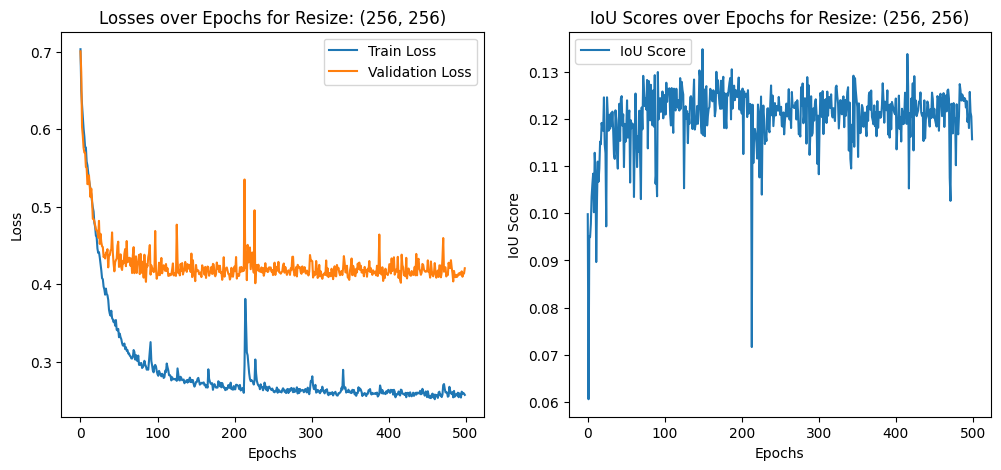

In [9]:
# Training Loop

# Input sizes to test
sizes = [(256, 256), ]
# Number of epochs for training
num_epochs = 500
# Get the base path of the project
base_path = os.getcwd()
# Path to images
base_path = os.path.join(base_path, 'MBDS/png')
# Initialize the best loss as infinity
best_loss = float('inf')

for resize in sizes:
    print(f"Training model with image size: {resize}")
    # Create dataloaders for training and validation
    train_loader, val_loader = create_dataloaders(base_path, resize, batch_size=4)

    # Initialize lists to store losses and IoU scores
    train_losses = []
    val_losses = []
    iou_scores = []

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        train_tqdm = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} Training', leave=True)
        for images, masks in train_tqdm:
            images, masks = images.to(device), masks.to(device)
            
            optimizer.zero_grad()  # Reset optimizer gradients
            outputs = model(images)  # Pass images through the model
            loss = criterion(outputs, masks)  # Calculate loss
            loss.backward()  # Backpropagate the error
            optimizer.step()  # Update weights
            
            running_loss += loss.item() * images.size(0)  # Accumulate scaled loss by batch size
            train_tqdm.set_postfix(loss=(running_loss / (train_tqdm.last_print_n + 1)))  # Update tqdm info
        
        epoch_loss = running_loss / len(train_loader.dataset)  # Calculate average loss for the epoch
        train_losses.append(epoch_loss)

        # Validation process to evaluate the model
        model.eval()  # Set the model to evaluation mode
        val_running_loss = 0.0
        ious = []
        val_tqdm = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} Validation', leave=True)
        with torch.no_grad():  # Disable gradient computation for validation
            for images, masks in val_tqdm:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_running_loss += loss.item() * images.size(0)
                
                iou = calculate_iou(outputs, masks)  # Calculate IoU
                ious.append(iou)
        
        val_epoch_loss = val_running_loss / len(val_loader.dataset)  # Average validation loss
        average_iou = np.mean(ious)  # Average IoU
        val_losses.append(val_epoch_loss)
        iou_scores.append(average_iou)
        
        # Print training and validation statistics
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Average IoU: {iou_scores[-1]:.4f}')

        # Save the model if the validation loss is the lowest so far
        if val_epoch_loss < best_loss:
            model_save_path = os.path.join('saved_models', f'model_{resize[0]}x{resize[1]}.pth')
            os.makedirs('saved_models', exist_ok=True)
            torch.save(model.state_dict(), model_save_path)
            print(f"Model saved to {model_save_path}")
            best_loss = val_epoch_loss

    # Visualize graphs of losses and IoU
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title(f'Losses over Epochs for Resize: {resize}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(iou_scores, label='IoU Score')
    plt.title(f'IoU Scores over Epochs for Resize: {resize}')
    plt.xlabel('Epochs')
    plt.ylabel('IoU Score')
    plt.legend()
    plt.show()

    model.apply(weight_reset)  # Reset model weights for the next size configuration

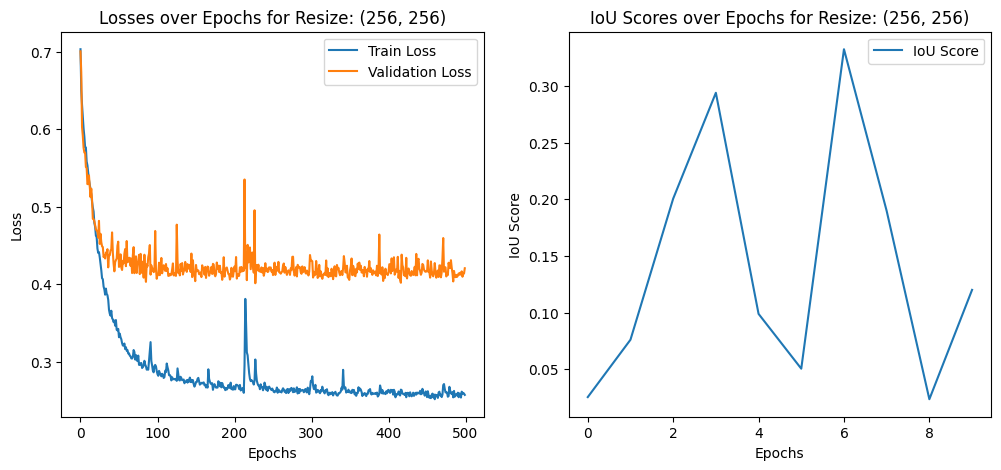

In [12]:
    # Visualize graphs of losses and IoU
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title(f'Losses over Epochs for Resize: {resize}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(iou_scores, label='IoU Score')
    plt.title(f'IoU Scores over Epochs for Resize: {resize}')
    plt.xlabel('Epochs')
    plt.ylabel('IoU Score')
    plt.legend()
    plt.show()

In [10]:
# Finally, we evaluate the model on the test set. 
# Besides the metrics, I think it's useful to see some examples where the original image, the true mask, and the predicted mask are displayed.

def create_test_dataloader(base_path, batch_size, resize):
    """
    Creates a DataLoader for the test dataset.

    Args:
        base_path (str): Base path where images and masks are stored.
        batch_size (int): Batch size.
        resize (tuple): Dimensions to which images and masks will be resized.

    Returns:
        DataLoader: DataLoader object configured for the test dataset.
    """
    # Transformations applied to the images
    transform_image = Compose([
        Resize(resize),
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Transformations applied to the masks (only resizing and tensor conversion)
    transform_mask = Compose([
        Resize(resize),
        ToTensor()
    ])
    
    # Create the dataset using the specified directories
    test_dir = os.path.join(base_path, 'test')
    test_mask_dir = os.path.join(base_path, 'test_labels')
    test_dataset = SatelliteBuildingDataset(test_dir, test_mask_dir, transform_image, transform_mask)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return test_loader

def plot_examples(data_loader, model, device, num_examples=5):
    """
    Displays examples of images, their true masks, and model predictions.

    Args:
        data_loader (DataLoader): DataLoader containing the test dataset.
        model (nn.Module): Neural network model to generate predictions.
        device (torch.device): Device where the model is running (CPU or GPU).
        num_examples (int): Number of examples to visualize.
    """
    fig, axs = plt.subplots(num_examples, 3, figsize=(15, num_examples * 5))
    model.eval()

    for idx, (images, masks) in enumerate(data_loader):
        if idx >= num_examples:
            break
        images, masks = images.to(device), masks.to(device)
        with torch.no_grad():
            outputs = model(images)
            preds = torch.sigmoid(outputs) > 0.5  # Convert logits to binary predictions

        # Visualize the original image, the true mask, and the predicted mask
        axs[idx, 0].imshow(images[0].cpu().permute(1, 2, 0))
        axs[idx, 0].set_title('Original Image')
        axs[idx, 0].axis('off')

        axs[idx, 1].imshow(masks[0].cpu().squeeze(), cmap='gray')
        axs[idx, 1].set_title('True Mask')
        axs[idx, 1].axis('off')

        axs[idx, 2].imshow(preds[0].cpu().squeeze(), cmap='gray')
        axs[idx, 2].set_title('Predicted Mask')
        axs[idx, 2].axis('off')

    plt.show()

Mean IoU for size (256, 256): 0.1411


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


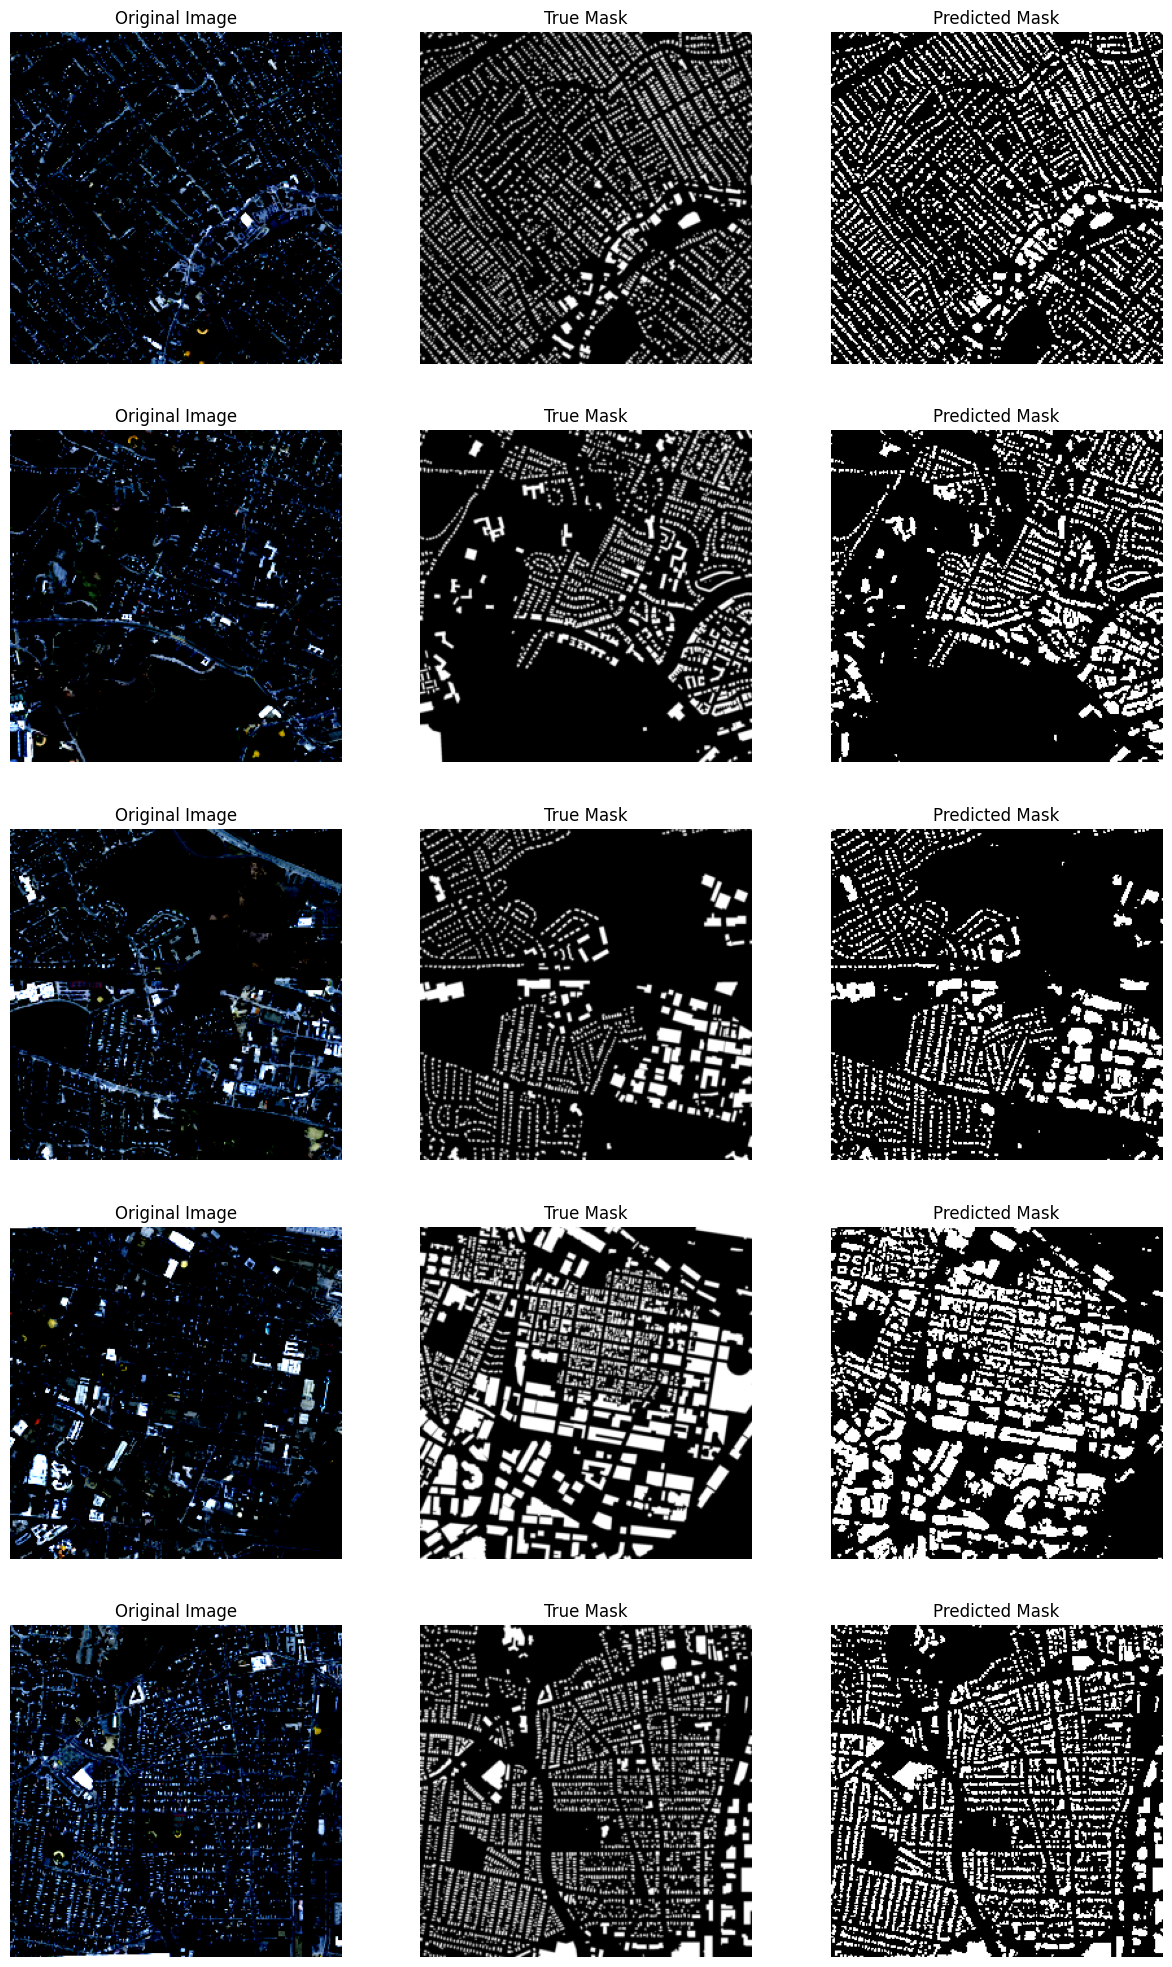

In [11]:
batch_size = 1

for resize in sizes:
    model_path = f'saved_models/model_{resize[0]}x{resize[1]}.pth'
    test_loader = create_test_dataloader(base_path, batch_size, resize)
    
    model = UNet()  # Assume the model has been previously defined
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()
    
    iou_scores = []  # List to store IoU scores

    for images, true_masks in test_loader:
        images = images.to(device)
        true_masks = true_masks.to(device)

        with torch.no_grad():
            outputs = model(images)
            preds = torch.sigmoid(outputs) > 0.5  # Threshold to obtain binary masks

        preds_np = preds.cpu().numpy().astype(np.uint8)
        true_masks_np = true_masks.cpu().numpy().astype(np.uint8)

        # Calculate and store the IoU score for each image in the batch
        for pred, true_mask in zip(preds_np, true_masks_np):
            iou_score = jaccard_score(true_mask.flatten(), pred.flatten())
            iou_scores.append(iou_score)

    mean_iou = np.mean(iou_scores)  # Calculate the mean IoU for the current size
    print(f'Mean IoU for size {resize}: {mean_iou:.4f}')
    plot_examples(test_loader, model, device, num_examples=5)  # Visualize examples of predictions